# <font color = 'blue'> __Lattice Graph Examples - Code__
We will consider the case of the time-homogeneous lattice, the time-inhomogeneous lattice that was presented in the examples of the paper.


# <font color = 'blue'> __Directory__
- [Computation of Transition Matrix for $n \times n$ Lattice](#TM_code)
- [Further Transition Statistics for Time Homogeneous Lattice](#TransitionStats)
- [Examples for Transition Matrix with Time-Homogeneous Dynamics and Inaccessible States](#absstate)
- [Examples for Transition Matrix with Non-Time Homogeneous Dynamics](#NonTH)

In [3]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns

sns.set_style('whitegrid')


## <a id='TM_code'> <font color = 'blue'> __Computing Transition Matrix of $n \times n$ Lattice in the Time-Homogeneous Case__</a>

In [5]:
def lattice_constructor(n):
    transition_matrix = np.zeros((n ** 2, n ** 2)) # Initialises the transition matrix object
    for i in range(n ** 2):
        
        nb_unadjusted = np.array([i - n, i - 1, i + 1, i + n]) # Calculate the potential neighbours
        nb = list(nb_unadjusted[(nb_unadjusted >= 0) & (nb_unadjusted < n ** 2)]) # Removes neighbours that are in undefined row entries
        if ((i % n) == 0) & (i != 0): # Removes neighbours that are in undefined columns
            nb.remove(i - 1)
            
        if ((i % n) == n - 1) & (i != (n ** 2) - 1): 
            nb.remove(i + 1)
            
        for j in nb:
            transition_matrix[i, j] = (1 / (len(nb)))
    
    return transition_matrix

In [6]:
m = 4
num_states = m ** 2
N = 20


""" Basics of the Markov Chain """
# Forward chain and initial distribution
P_base = lattice_constructor(m) # Makes the base transition matrix - will need to be changed to the form compatible with the functionality later
initial_dist = np.array([1 / num_states for i in range(num_states)]) # Initial distibution 

# Reverse process
from tpt_gc import calc_reverse_process, calc_forward_comms, calc_backward_comms

# The following step is to make P_tim_hom compatible with the reverse_process function:
P = np.zeros((N, num_states, num_states))
P[0:N] = P_base # applying numpy broadcasting feature 
P_reverse, distributions = calc_reverse_process(P, initial_dist, N)


""" Transition path theory"""
# Reactant and target sets:
A = [0] 
B = [15] 

# Forward and backward committors
forward_comms = calc_forward_comms(P, N, A, B)
backward_comms = calc_backward_comms(P_reverse, N, A, B)

"""Calculating transition statistics"""
from tpt_gc import calc_reactive_dist, calc_cond_reactive_dist, calc_prob_current, calc_effec_current

reactive_dist = calc_reactive_dist(distributions, forward_comms, backward_comms)
cond_reactive_dist = calc_cond_reactive_dist(reactive_dist)
prob_current = calc_prob_current(forward_comms, backward_comms, distributions, P)
effec_current = calc_effec_current(prob_current)

C:\Users\trund\URSS\tpt_gc.py:272: RuntimeWarning: invalid value encountered in divide
  cond_reactive_dist = np.nan_to_num(reactive_distributions / np.sum(reactive_distributions, axis=1).reshape(len(reactive_distributions), 1))


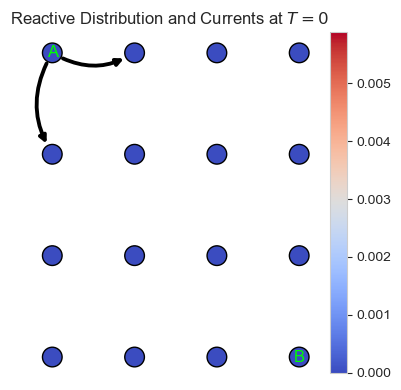

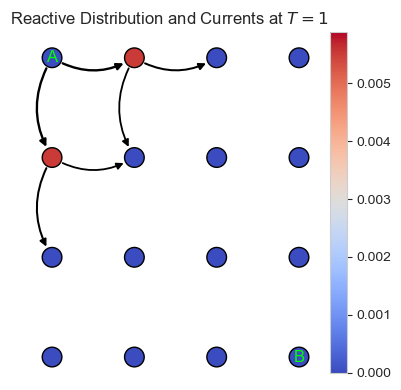

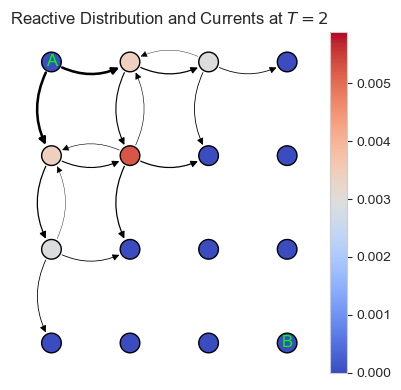

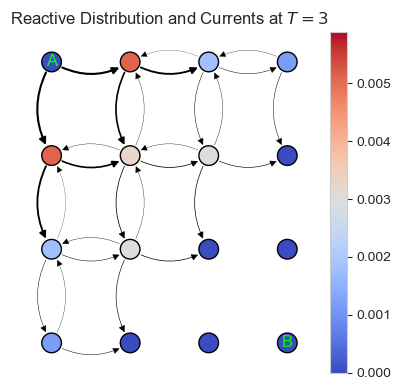

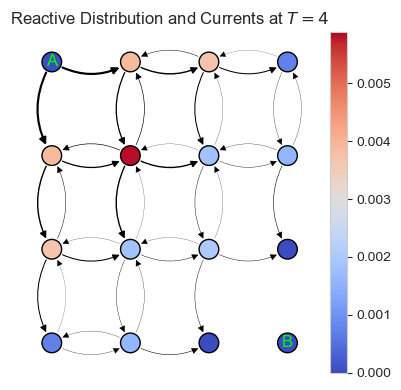

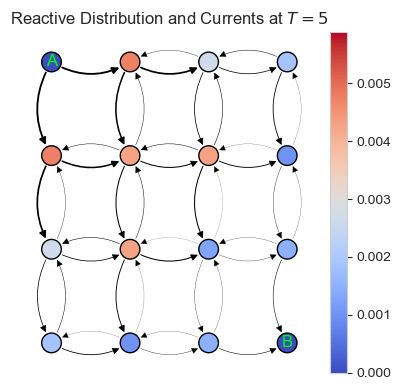

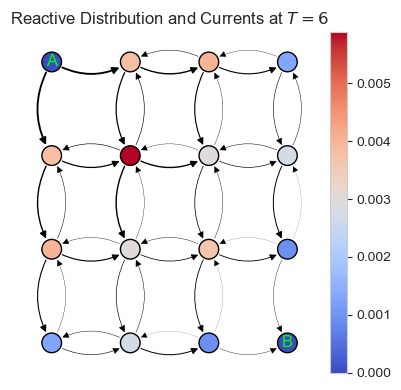

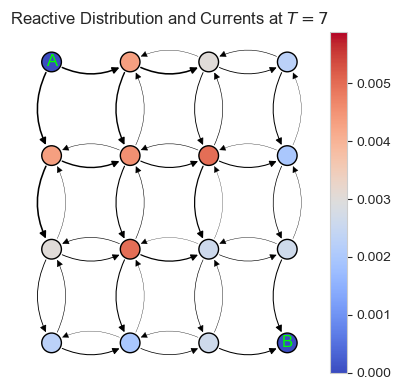

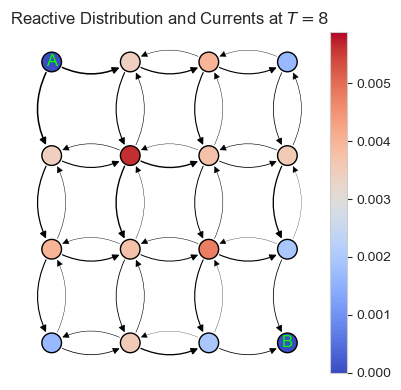

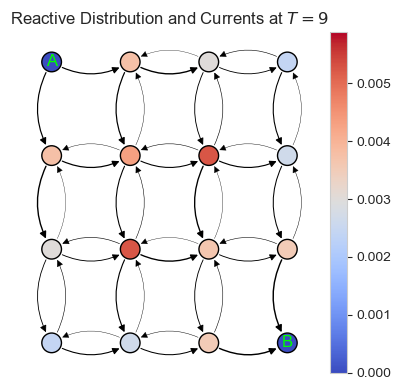

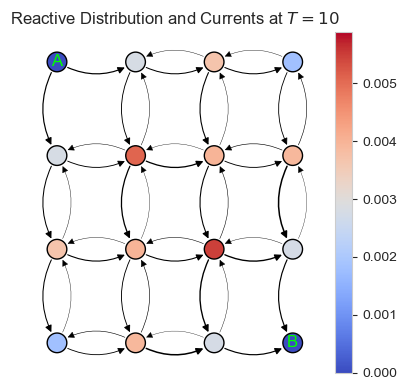

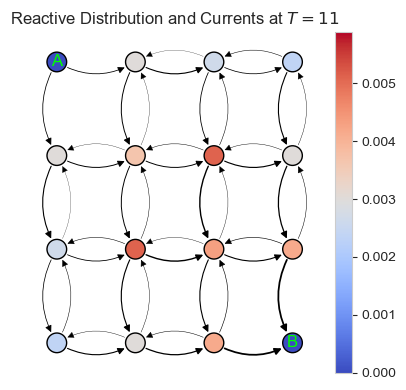

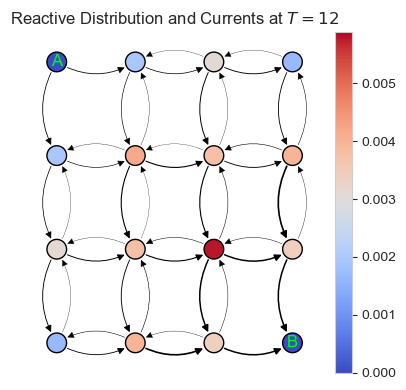

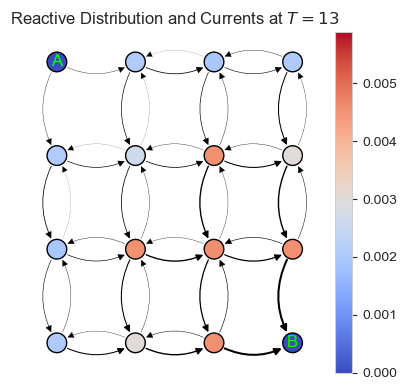

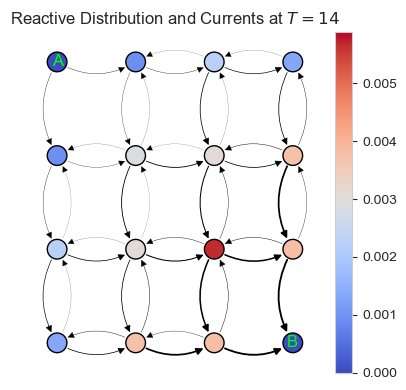

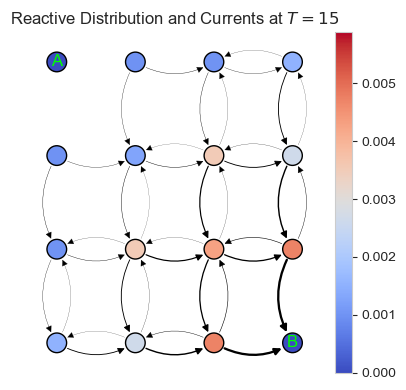

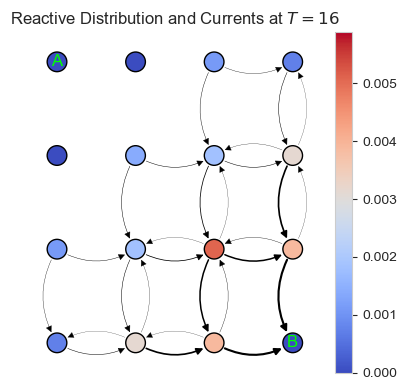

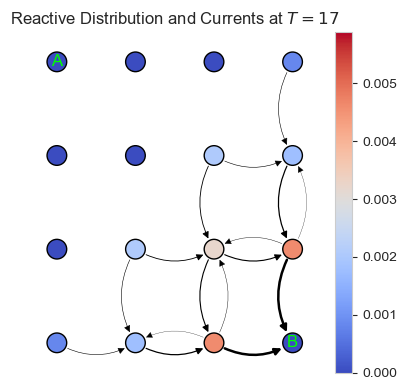

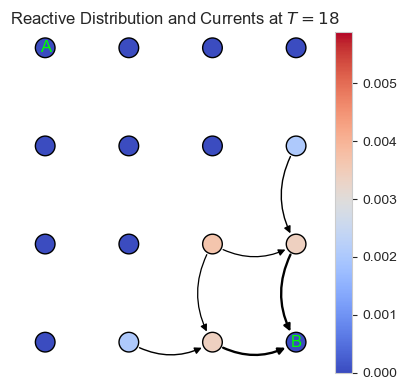

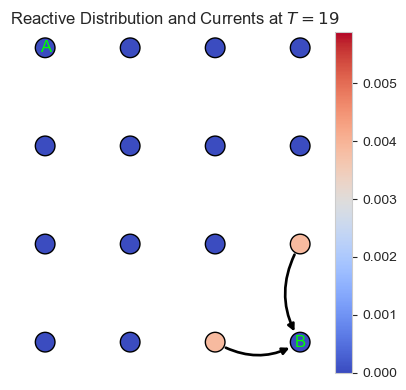

In [7]:
# Plotting the evolution of the reactive distributions
import networkx as nx
from lattice_visual import draw_reactive_distributions

for n in range(N):
    draw_reactive_distributions(m, N, A, B, reactive_dist, prob_current, n)
    plt.tight_layout()
    plt.show()

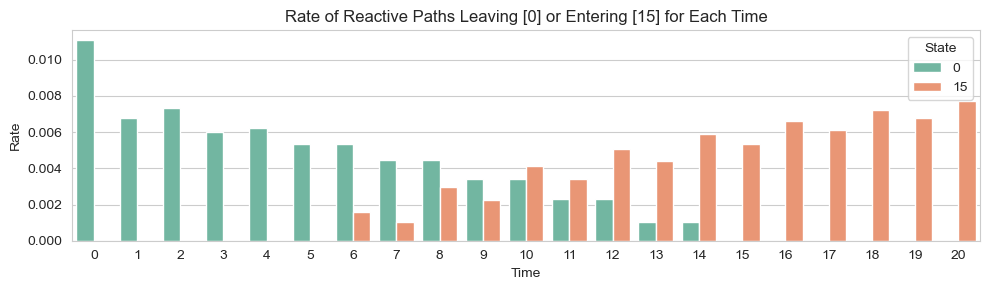

In [8]:
from tpt_gc import calc_rate
from lattice_visual import rates_visualisation

rates_A, rates_B = calc_rate(prob_current, A, B)
time_index = np.arange(N + 1)
#rates_visualisation(m, N, A, B, rates)
fig, ax= plt.subplots(figsize=(10,3))
data = pd.DataFrame({
    'Rate':np.concatenate([rates_A, rates_B]), 
    'Time':np.tile(time_index, 2),
    'State':np.repeat(A + B, N + 1)}
)
sns.barplot(data, x="Time", y="Rate", hue="State", palette="Set2")
ax.set_title(f"Rate of Reactive Paths Leaving {A} or Entering {B} for Each Time")
plt.tight_layout()
#plt.savefig('Rates/Barplot of Rates.png')
plt.show()

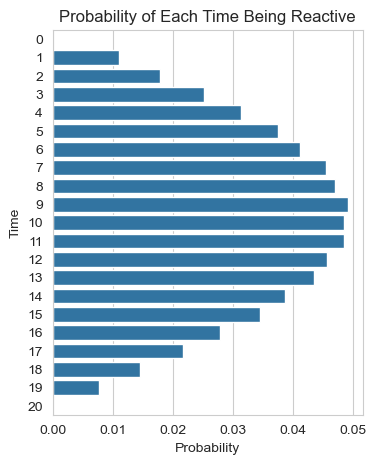

In [9]:
"""Probability that a time is reactive"""
time_reactive_prob = reactive_dist.sum(axis=1)
time_index = np.arange(N + 1)
time_data = pd.DataFrame({
    'Probability':time_reactive_prob,
    'Time':time_index
})

def barplot(data, X, Y, orient, title, figsize):
    fig, ax = plt.subplots(figsize=figsize)
    sns.barplot(data=data, x=X, y=Y, ax=ax, orient=orient)
    ax.set_title(title)
    ax.set_ylabel(Y, fontsize=10)
    ax.set_xlabel(X, fontsize=10)
    #plt.savefig(title + '.png')
    plt.show()
    return

title = 'Probability of Each Time Being Reactive'
barplot(time_data, 'Probability', 'Time', 'h', title, (4,5))

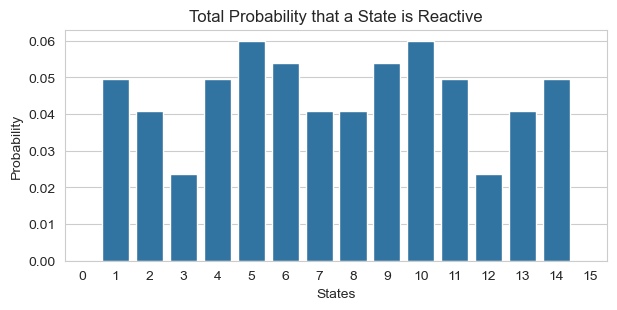

In [10]:
state_reactive_prob = reactive_dist.sum(axis=0)
state_index =  np.arange(num_states)
data = pd.DataFrame({
    'States':state_index,
    'Probability':state_reactive_prob
})

barplot(data, 'States', 'Probability', 'v', "Total Probability that a State is Reactive", (7,3))


In [11]:
from bottleneck_tpt import MetaGraph

meta_graph = MetaGraph(effec_current, A, B)
print(meta_graph.find_dominant_path())
print(meta_graph.find_bottleneck())

[(6, 0), (7, 1), (8, 5), (9, 6), (10, 10), (11, 14), (12, 15)]
[(10, 10), (11, 14)]


## <a id='absstate'> <font color = 'blue'> __TPT on $m \times m$ Lattice with Inaccessible States__ </a>

In [13]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns

sns.set_style('whitegrid')


In [14]:
from tpt_gc import calc_reverse_process, calc_forward_comms, calc_backward_comms, calc_prob_current, calc_reactive_dist

def walled_lattice_constructor(n, cut):
    
    transition_matrix = np.zeros((n ** 2, n ** 2)) # Initialises the transition matrix object
    for i in range(n**2):

        if i in cut: 
            transition_matrix[i, i] = 1
            continue

        if i % n == 0:
            nb_unadjusted = np.array([i - n,  i + 1, i + n]) # Removes left neighbour if i is on the left border
        elif i % n == n - 1:
            nb_unadjusted = np.array([i - n,  i - 1, i + n]) # Removes right neighbour if i is on the right border
        else:
            nb_unadjusted = np.array([i - n, i - 1, i + 1, i + n]) # Calculate the potential neighbours
        nb = list(nb_unadjusted[(nb_unadjusted >= 0) 
                  & (nb_unadjusted < n ** 2) 
                  & ~np.in1d( nb_unadjusted, np.array(cut) )])    # Removes neighbours that are on undefined entries

#        if ((i % n) == 0) & (i != 0): # Removes left neighbour if i is on the left border
#            nb.remove(i - 1)
            
#        if ((i % n) == n - 1) & (i != (n ** 2) - 1): # Removes right neighbour if i is on the right border
#            nb.remove(i + 1)
            
        for j in nb:
            transition_matrix[i, j] = (1 / (len(nb)))
    
    return transition_matrix

"""Creating the new Markov Chain"""
from tpt_gc import calc_reverse_process, calc_forward_comms, calc_backward_comms, calc_prob_current, calc_reactive_dist
m = 4
num_states = m ** 2
N = 20

states_to_cut = [2,6,10]
P_base = walled_lattice_constructor(m, states_to_cut)
P = np.zeros((N, num_states, num_states))
P[0:N] = P_base
initial_dist = np.array([1 / num_states for i in range(num_states)])

# Reverse chain 
P_reverse, distributions = calc_reverse_process(P, initial_dist, N)


"""For Transition Path Theory"""
A = [0]
B = [3]

forward_comms, backward_comms = calc_forward_comms(P, N, A, B), calc_backward_comms(P_reverse, N, A, B)
reactive_dist = calc_reactive_dist(distributions, forward_comms, backward_comms)
prob_current = calc_prob_current(forward_comms, backward_comms, distributions, P)

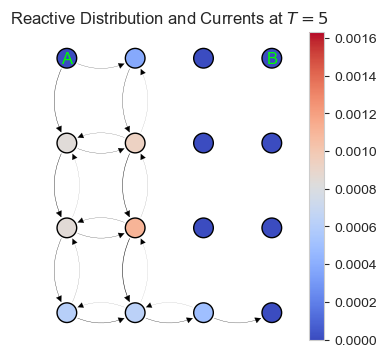

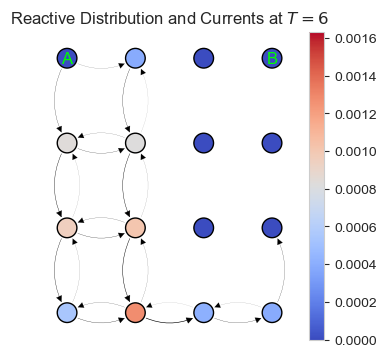

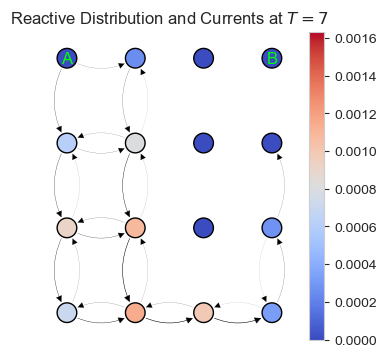

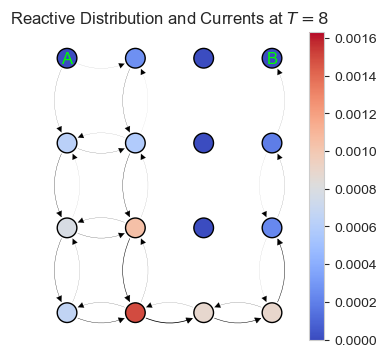

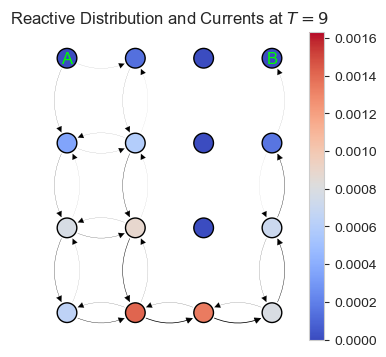

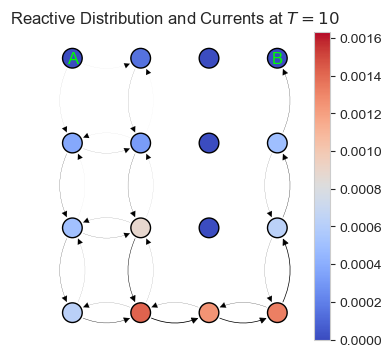

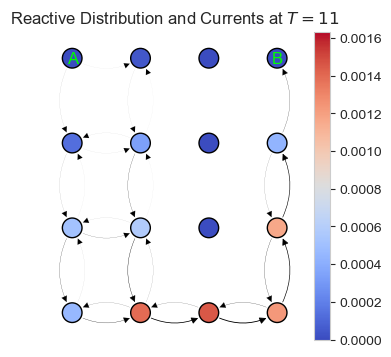

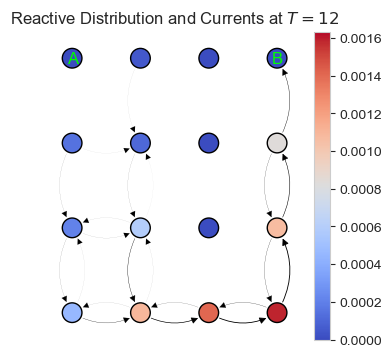

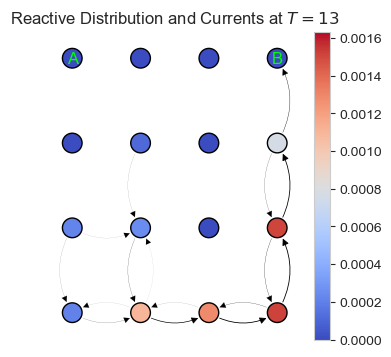

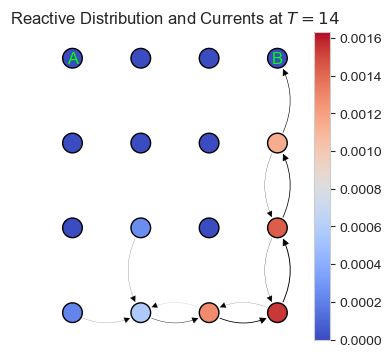

In [15]:
from lattice_visual import draw_reactive_distributions

for n in range(5,15):
    draw_reactive_distributions(m, N, A, B, reactive_dist, prob_current, n)

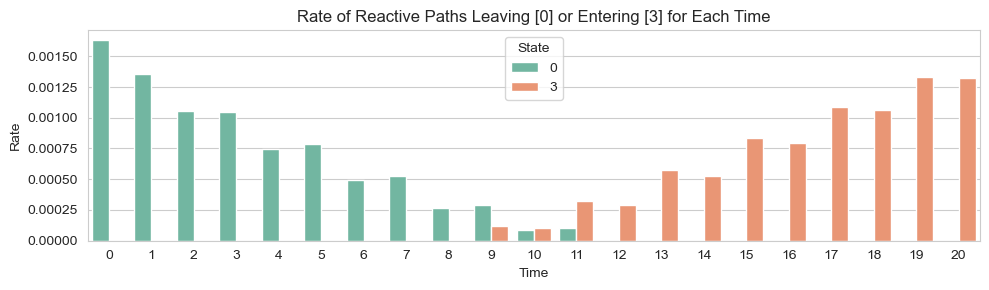

In [16]:
from tpt_gc import calc_rate

rates_A, rates_B = calc_rate(prob_current, A, B)
time_index = np.arange(N + 1)

fig, ax= plt.subplots(figsize=(10,3))
data = pd.DataFrame({
    'Rate':np.concatenate([rates_A, rates_B]), 
    'Time':np.tile(time_index, 2),
    'State':np.repeat(A + B, N + 1)}
)
sns.barplot(data, x="Time", y="Rate", hue="State", palette="Set2")
ax.set_title(f"Rate of Reactive Paths Leaving {A} or Entering {B} for Each Time")
plt.tight_layout()
plt.show()

# <a id='NonTH'> <font color='blue'> __$m \times m$ Lattice with Non-Time-Homogeneous Dynamics__ </a>

The lattice can be described with moving with equal probability to all its neighbours, except the states $(1,2), (2,2)$ are removed from the lattice.

In [18]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns

sns.set_style('whitegrid')

In [19]:
def non_timehom_lattice(m, cut):

    # m = dimensions of lattice
    transition_matrix = np.zeros((m ** 2, m ** 2)) 
    for i in range(m ** 2):
        
        if i in cut: 
            transition_matrix[i, i] = 1
            continue
    
        if i % m == 0:
            nb_unadjusted = np.array([i - m,  i + 1, i + m]) # Removes left neighbour if i is on the left border
        elif i % m == m - 1:
            nb_unadjusted = np.array([i - m,  i - 1, i + m]) # Removes right neighbour if i is on the right border
        else:
            nb_unadjusted = np.array([i - m, i - 1, i + 1, i + m]) # Calculate the potential neighbours
        nb = list(nb_unadjusted[(nb_unadjusted >= 0) 
                  & (nb_unadjusted < m ** 2) 
                  & ~np.in1d( nb_unadjusted, np.array(cut) )])    # Removes neighbours that are on undefined entries

        for j in nb:
                transition_matrix[i, j] = (1 / (len(nb)))

    return transition_matrix

In [20]:
"""Markov Chain"""
# Setting up state space and time 
m = 4
num_states = m ** 2
N = 20

# Transition matrices
first_half_matrix = non_timehom_lattice(m, [6, 10, 14])
second_half_matrix = non_timehom_lattice(m, [2,6,10])
cutoff_time = 4

P = np.zeros((N, num_states, num_states))
P[:cutoff_time] = first_half_matrix
P[cutoff_time:] = second_half_matrix
initial_dist = [1 / num_states for i in range(num_states)]

# Reverse process
from tpt_gc import calc_reverse_process
P_reverse, dist = calc_reverse_process(P, initial_dist, N)


"""
TPT
"""
# Reactant and Target Set
A = [4]
B = [11]

# Committors and transition statistics
from tpt_gc import calc_forward_comms, calc_backward_comms, calc_prob_current, calc_reactive_dist, calc_effec_current
forward_comms, backward_comms = calc_forward_comms(P, N, A, B), calc_backward_comms(P_reverse, N, A, B)
reactive_dist = calc_reactive_dist(dist, forward_comms, backward_comms)
prob_current = calc_prob_current(forward_comms, backward_comms, dist, P)
effec_current = calc_effec_current(prob_current)

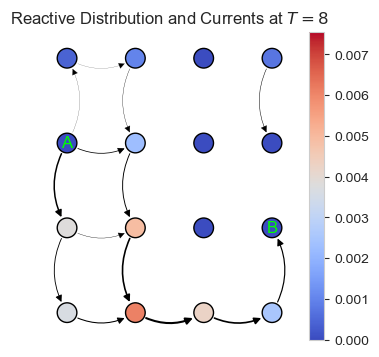

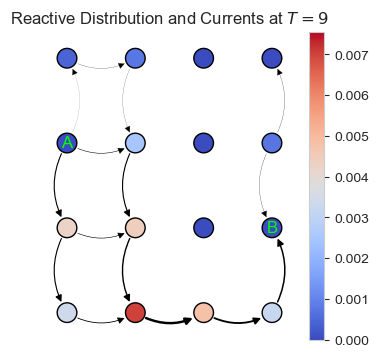

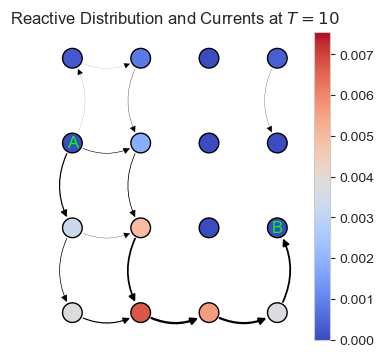

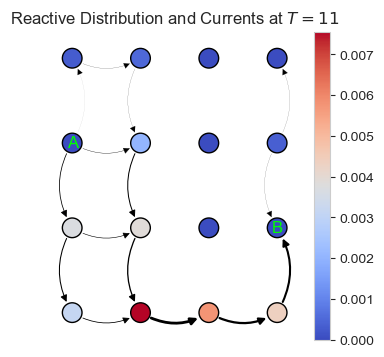

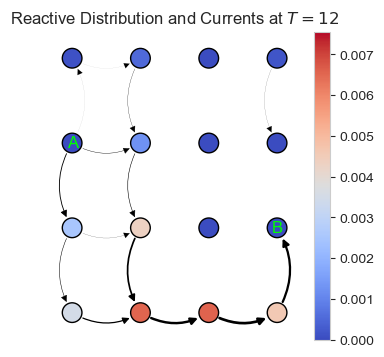

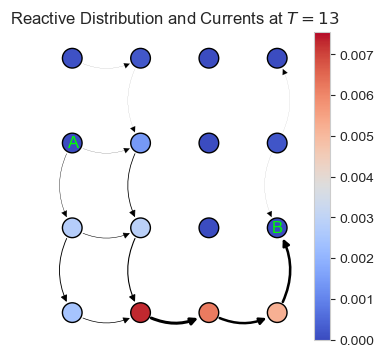

In [21]:
from lattice_visual import draw_reactive_distributions

for t in [8,9,10,11,12,13]:
    draw_reactive_distributions(m, N, A, B, reactive_dist, effec_current, t)
    #plt.savefig(f'NonTHT{t}.png')
    plt.show()
    

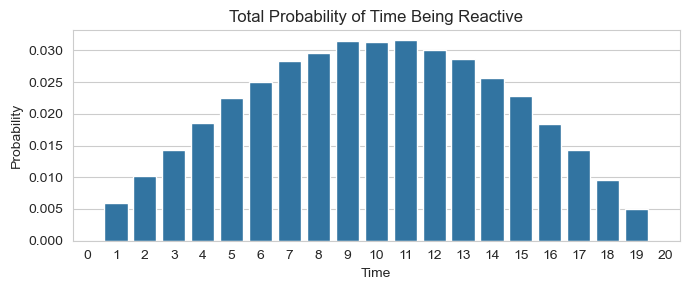

In [22]:
def barplot_time():
    time_index = np.arange(N+1)
    prob_time_reactive = np.sum(reactive_dist, axis=1)
    
    data = pd.DataFrame({
        'Time':time_index,
        'Probability': prob_time_reactive
    })

    fig, ax = plt.subplots(figsize=(7,3))
    sns.barplot(data, x='Time', y='Probability', orient='v', ax=ax)
    ax.set_title('Total Probability of Time Being Reactive', fontsize=12)
    plt.tight_layout()
    plt.show()

    return

barplot_time()

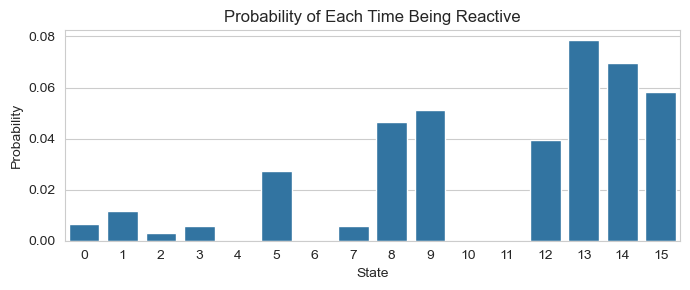

In [23]:
def barplot_state():
    state_index = np.arange(num_states)
    prob_state_reactive = np.sum(reactive_dist, axis=0)
    
    data = pd.DataFrame({
    'State':state_index,
    'Probability': prob_state_reactive
    })
    
    fig, ax = plt.subplots(figsize=(7,3))
    sns.barplot(data, x='State', y='Probability', orient='v', ax=ax)
    
    ax.set_title(title, fontsize=12)
    plt.tight_layout()
    plt.savefig('TimeInhomStatePlot.png')
    plt.show()

    return
barplot_state()

In [24]:
from bottleneck_tpt import MetaGraph

meta_graph = MetaGraph(effec_current, A, B)
print(meta_graph.find_dominant_path())
print(meta_graph.find_bottleneck())

[(8, 4), (9, 8), (10, 12), (11, 13), (12, 14), (13, 15), (14, 11)]
[(9, 8), (10, 12)]
